**数据集：**
- Day 1-6: Train
- Day 7-10: Validation
- Day 11-13: Test

**预测目标：**
超短期预测（4h/15min）的风功率

In [2]:
# 数据集特征
n_back = 200
n_out = 16
n_pre = n_out*15*2
n_feature = 2

train_day = 6
validation_day = 4
test_day = 3

# 神经网络参数
import numpy as np
units = np.arange(20, 60, 10)
batch_size = 32
epochs = 50
units

array([20, 30, 40, 50])

# Preperation

In [3]:
from math import sqrt
import numpy as np
import pandas as pd
import pickle

from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU

2023-01-12 10:28:43.322692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 10:28:43.848106: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-12 10:28:43.848208: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-12 10:28:46.383910: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
dataset = pd.read_csv('../../wind_preprocessed.csv', header=0, index_col=0).query('day<14')

In [5]:
data = dataset[['speed_moveavg', 'power_moveavg']].rename(columns={'power_moveavg':'power', 'speed_moveavg':'speed'})
print(data.head())

                       speed    power
date                                 
2015-10-01 00:00:00  0.39627  0.38065
2015-10-01 00:00:30  0.39592  0.36943
2015-10-01 00:01:00  0.39538  0.38529
2015-10-01 00:01:30  0.39579  0.38892
2015-10-01 00:02:00  0.39627  0.41220


In [6]:
values = data.values
values = values.astype('float32')

def series_to_supervised(data, n_in, n_out, colname, dropnan=True):
    n_vars = colname
    # n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in n_vars]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out, 15*2):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in n_vars]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in n_vars]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 构建成监督学习问题
reframed = series_to_supervised(values, n_back, n_pre, ['speed', 'power'])
# 丢弃我们不想预测的列
for i in range(0, n_pre, 15*2):
    if i == 0:
        colname = 'speed(t)'
    else:
        colname = f'speed(t+{i})'
    reframed.drop(colname, axis=1, inplace=True)
# print(reframed.head(5))

In [7]:
# 分割为训练集和测试集
values = reframed.values
n_train = train_day*24*60*2
n_validation = validation_day*24*60*2
n_test = test_day*24*60*2
train = values[:n_train, :]
validation = values[n_train:n_train+n_validation, :]
test = values[-n_test:, :]
# 分为输入输出
n_obs = n_back * n_feature
train_X, train_y = train[:, :n_obs], train[:, -n_out:]
validation_X, validation_y = validation[:, :n_obs], validation[:, -n_out:]
test_X, test_y = test[:, :n_obs], test[:, -n_out:]
# 重塑成3D格式 [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_back, n_feature))
validation_X = validation_X.reshape((validation_X.shape[0], n_back, n_feature))
test_X = test_X.reshape((test_X.shape[0], n_back, n_feature))
print(train_X.shape, train_y.shape)
print(validation_X.shape, validation_y.shape)
print(test_X.shape, test_y.shape)

(17280, 200, 2) (17280, 16)
(11520, 200, 2) (11520, 16)
(8640, 200, 2) (8640, 16)


# Training

---Start Unit 40---


2023-01-12 10:28:54.587635: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-12 10:28:54.587806: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-12 10:28:54.587882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-VC833VJB): /proc/driver/nvidia/version does not exist
2023-01-12 10:28:54.588852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
540/540 [==============================] - 164s 290ms/step - loss: 0.0255 - val_loss: 0.0277
Epoch 2/50
540/540 [==============================] - 135s 251ms/step - loss: 0.0298 - val_loss: 0.0262
Epoch 3/50
540/540 [==============================] - 146s 271ms/step - loss: 0.0318 - val_loss: 0.0224
Epoch 4/50
540/540 [==============================] - 134s 248ms/step - loss: 0.0306 - val_loss: 0.0216
Epoch 5/50
540/540 [==============================] - 149s 276ms/step - loss: 0.0303 - val_loss: 0.0210
Epoch 6/50
540/540 [==============================] - 148s 273ms/step - loss: 0.0296 - val_loss: 0.0200
Epoch 7/50
540/540 [==============================] - 164s 304ms/step - loss: 0.0285 - val_loss: 0.0189
Epoch 8/50
540/540 [==============================] - 146s 271ms/step - loss: 0.0279 - val_loss: 0.0183
Epoch 9/50
540/540 [==============================] - 162s 301ms/step - loss: 0.0274 - val_loss: 0.0175
Epoch 10/50
540/540 [==============================] - 150s 277m

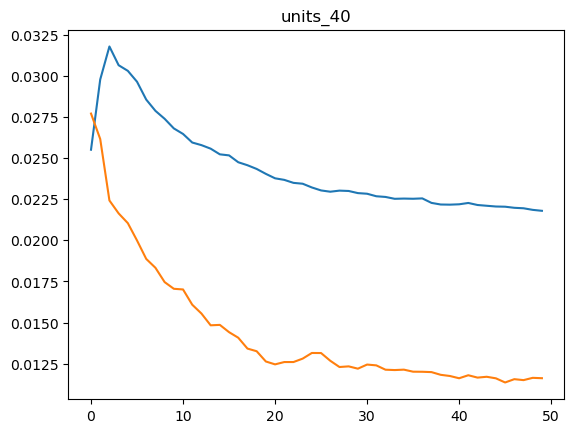

---Finish Unit 40---


In [8]:
def train(u):
    print(f'---Start Unit {u}---')
    # 设计网络
    model = Sequential()
    model.add(GRU(u, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(n_out))

    # 拟合神经网络模型
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(validation_X, validation_y), verbose=1, shuffle=False)
    
    # 保存模型及训练历史
    model.save_weights(f'{u}.h5')
    with open(f'lstm_unit{u}_hist.pickle', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # 画图
    fig,ax = plt.subplots()
    ax.plot(history.history['loss'], label='train')
    ax.plot(history.history['val_loss'], label='test')
    plt.title(f'units_{u}')
    plt.show()

    print(f'---Finish Unit {u}---')

train(40)
# from multiprocessing.pool import ThreadPool
# pool = ThreadPool(len(units))  # 创建一个线程池
# pool.map(train, units)  # 往线程池中填线程
# pool.close()  # 关闭线程池，不再接受线程
# pool.join()  # 等待线程池中线程全部执行完

---Start Unit 50---
Epoch 1/50
540/540 [==============================] - 138s 249ms/step - loss: 0.0229 - val_loss: 0.0342
Epoch 2/50
540/540 [==============================] - 134s 248ms/step - loss: 0.0306 - val_loss: 0.0261
Epoch 3/50
540/540 [==============================] - 133s 247ms/step - loss: 0.0298 - val_loss: 0.0225
Epoch 4/50
540/540 [==============================] - 132s 245ms/step - loss: 0.0298 - val_loss: 0.0216
Epoch 5/50
540/540 [==============================] - 133s 247ms/step - loss: 0.0297 - val_loss: 0.0208
Epoch 6/50
540/540 [==============================] - 132s 245ms/step - loss: 0.0290 - val_loss: 0.0204
Epoch 7/50
540/540 [==============================] - 134s 248ms/step - loss: 0.0286 - val_loss: 0.0190
Epoch 8/50
540/540 [==============================] - 134s 249ms/step - loss: 0.0280 - val_loss: 0.0187
Epoch 9/50
540/540 [==============================] - 141s 261ms/step - loss: 0.0274 - val_loss: 0.0176
Epoch 10/50
540/540 [=======================

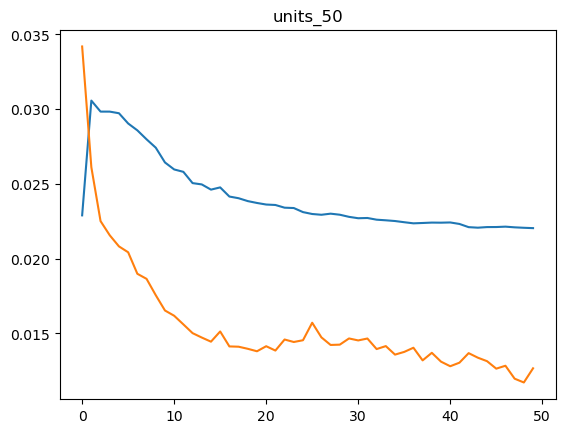

---Finish Unit 50---


In [9]:
train(50)